# Modelling Heteroscedastic Noise with Gaussian Processes via Kalman Smoothing

## Import and load data

loading data ...


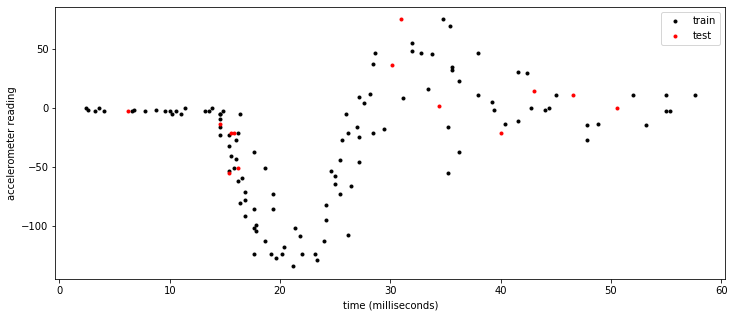

In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import time
from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
from sklearn.preprocessing import StandardScaler

plot_intermediate = False

print('loading data ...')
D = np.loadtxt('../../data/mcycle.csv', delimiter=',')
X = D[:, 1:2]
Y = D[:, 2:]
N = X.shape[0]

# Standardize
X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(Y)
Xall = X_scaler.transform(X)
Yall = y_scaler.transform(Y)

# Load cross-validation indices
cvind = np.loadtxt('../experiments/heteroscedastic/cvind.csv').astype(int)

# 10-fold cross-validation setup
nt = np.floor(cvind.shape[0]/10).astype(int)
cvind = np.reshape(cvind[:10*nt], (10, nt))

np.random.seed(123)
fold = 0

# Get training and test indices
test = cvind[fold, :]
train = np.setdiff1d(cvind, test)

# Set training and test data
X = Xall[train, :]
Y = Yall[train, :]
XT = Xall[test, :]
YT = Yall[test, :]

plt.figure(1, figsize=(12, 5))
plt.clf()
plt.plot(X_scaler.inverse_transform(X), y_scaler.inverse_transform(Y), 'k.', label='train')
plt.plot(X_scaler.inverse_transform(XT), y_scaler.inverse_transform(YT), 'r.', label='test')
plt.legend()
plt.xlabel('time (milliseconds)')
plt.ylabel('accelerometer reading');

## Build the GP model

In [2]:
var_f1 = 3.  # GP variance
len_f1 = 1.  # GP lengthscale
var_f2 = 3.  # GP variance
len_f2 = 1.  # GP lengthscale

prior1 = priors.Matern32(variance=var_f1, lengthscale=len_f1)
prior2 = priors.Matern32(variance=var_f2, lengthscale=len_f2)
prior = priors.Independent([prior1, prior2])
lik = likelihoods.HeteroscedasticNoise()

# inf_method = approx_inf.ExpectationPropagation(power=0.9, intmethod='UT', damping=0.1)
inf_method = approx_inf.ExpectationPropagation(power=0.01, intmethod='GH', damping=0.5)
# inf_method = approx_inf.VariationalInference(intmethod='GH', damping=0.5)
# inf_method = approx_inf.VariationalInference(intmethod='UT', damping=0.5)
# inf_method = approx_inf.ExtendedEP(power=0, damping=0.5)
# inf_method = approx_inf.ExtendedKalmanSmoother(damping=0.5)
# inf_method = approx_inf.GaussHermiteKalmanSmoother(damping=0.5)
# inf_method = approx_inf.StatisticallyLinearisedEP(intmethod='UT', damping=0.5)
# inf_method = approx_inf.UnscentedKalmanSmoother(damping=0.5)

model = SDEGP(prior=prior, likelihood=lik, t=X, y=Y, approx_inf=inf_method)

/Users/wilkinw1/Library/Python/3.7/lib/python/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


building SDE-GP with Independent prior and Heteroscedastic Noise likelihood ...
inference method is Expectation Propagation (EP)


## Set up the optimiser

In [3]:
opt_init, opt_update, get_params = optimizers.adam(step_size=5e-2)
# parameters should be a 2-element list [param_prior, param_likelihood]
opt_state = opt_init([model.prior.hyp, model.likelihood.hyp])


def gradient_step(i, state, mod):
    params = get_params(state)
    mod.prior.hyp = params[0]
    mod.likelihood.hyp = params[1]

    # grad(Filter) + Smoother:
    neg_log_marg_lik, gradients = mod.run()
    # neg_log_marg_lik, gradients = mod.run_two_stage()  # <-- less elegant but reduces compile time

    prior_params = softplus_list(params[0])
    if (i % 10) == 0:
        print('iter %2d: var_f1=%1.2f len_f1=%1.2f var_f2=%1.2f len_f2=%1.2f, nlml=%2.2f' %
              (i, prior_params[0][0], prior_params[0][1], prior_params[1][0], prior_params[1][1], neg_log_marg_lik))

    if plot_intermediate:
        plot(mod, i)

    return opt_update(i, gradients, state)

## Optimise the hyperparameters and site parameters

In [4]:
print('optimising the hyperparameters ...')
t0 = time.time()
for j in range(200):
    opt_state = gradient_step(j, opt_state, model)
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

optimising the hyperparameters ...
iter  0: var_f1=3.00 len_f1=1.00 var_f2=3.00 len_f2=1.00, nlml=80.49
iter 10: var_f1=3.01 len_f1=0.85 var_f2=3.47 len_f2=0.73, nlml=70.25
iter 20: var_f1=2.69 len_f1=0.90 var_f2=3.87 len_f2=0.55, nlml=68.32
iter 30: var_f1=2.43 len_f1=0.92 var_f2=4.11 len_f2=0.47, nlml=67.81
iter 40: var_f1=2.30 len_f1=0.85 var_f2=4.18 len_f2=0.48, nlml=67.79
iter 50: var_f1=2.06 len_f1=0.83 var_f2=4.19 len_f2=0.52, nlml=67.75
iter 60: var_f1=1.86 len_f1=0.79 var_f2=4.24 len_f2=0.54, nlml=67.72
iter 70: var_f1=1.67 len_f1=0.76 var_f2=4.32 len_f2=0.54, nlml=67.68
iter 80: var_f1=1.49 len_f1=0.72 var_f2=4.40 len_f2=0.54, nlml=67.63
iter 90: var_f1=1.37 len_f1=0.70 var_f2=4.46 len_f2=0.55, nlml=67.62
iter 100: var_f1=1.28 len_f1=0.68 var_f2=4.52 len_f2=0.56, nlml=67.63
iter 110: var_f1=1.24 len_f1=0.67 var_f2=4.58 len_f2=0.56, nlml=67.63
iter 120: var_f1=1.22 len_f1=0.66 var_f2=4.64 len_f2=0.56, nlml=67.62
iter 130: var_f1=1.23 len_f1=0.66 var_f2=4.70 len_f2=0.57, nlml=6

## Make predictions

In [5]:
x_plot = np.linspace(np.min(Xall)-0.2, np.max(Xall)+0.2, 200)
print('calculating the posterior predictive distribution ...')
t0 = time.time()
nlpd = model.negative_log_predictive_density(t=XT, y=YT)
posterior_mean, posterior_cov = model.predict(t=x_plot)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))
print('NLPD: %1.2f' % nlpd)

calculating the posterior predictive distribution ...
prediction time: 4.58 secs
NLPD: 0.34


## Plot the posterior

plotting ...


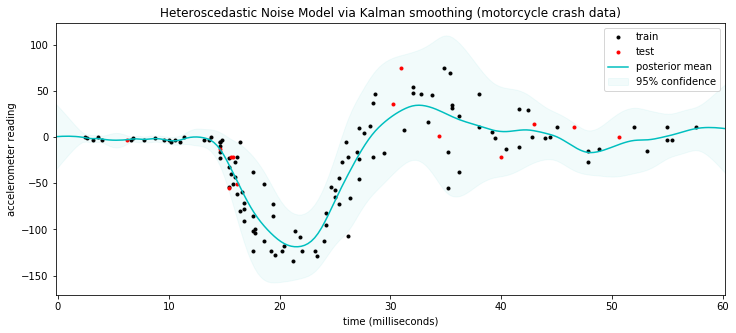

In [6]:
x_pred = X_scaler.inverse_transform(x_plot)
link = model.likelihood.link_fn
lb = posterior_mean[:, 0] - np.sqrt(posterior_cov[:, 0, 0] + link(posterior_mean[:, 1]) ** 2) * 1.96
ub = posterior_mean[:, 0] + np.sqrt(posterior_cov[:, 0, 0] + link(posterior_mean[:, 1]) ** 2) * 1.96
post_mean = y_scaler.inverse_transform(posterior_mean[:, 0])
lb = y_scaler.inverse_transform(lb)
ub = y_scaler.inverse_transform(ub)

print('plotting ...')
plt.figure(2, figsize=(12, 5))
plt.clf()
plt.plot(X_scaler.inverse_transform(X), y_scaler.inverse_transform(Y), 'k.', label='train')
plt.plot(X_scaler.inverse_transform(XT), y_scaler.inverse_transform(YT), 'r.', label='test')
plt.plot(x_pred, post_mean, 'c', label='posterior mean')
plt.fill_between(x_pred, lb, ub, color='c', alpha=0.05, label='95% confidence')
plt.xlim(x_pred[0], x_pred[-1])
plt.legend()
plt.title('Heteroscedastic Noise Model via Kalman smoothing (motorcycle crash data)')
plt.xlabel('time (milliseconds)')
plt.ylabel('accelerometer reading');